# Image classification using CNNs


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import random
import tensorflow as tf

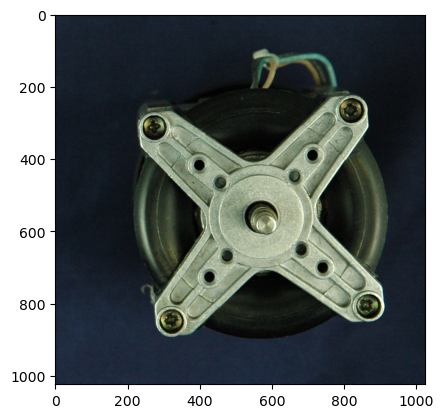

In [2]:
img = cv2.imread(r'./top/L1_C_3.JPG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
img.shape

(1024, 1024, 3)

In [4]:
import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Complete"
    return "n/a" # TODO: Raise error

def image_preprocessing(img, size = (64,32), flatten = True, color = False):
    img = cv2.resize(img, size)
    if not color:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if flatten:
        img = img.reshape(-1)
    return img

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], []
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = image_preprocessing(img, size, flatten, color)
            features.append(img)
            labels.append(get_label_from_name(file))   
    return features, labels

In [5]:
features, labels = load_features_labels("./top", size=(256,256), color=True, flatten=False, identifiers=['NS', 'MS', 'MC', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (117, 256, 256, 3)
Shape label vector: (117,)


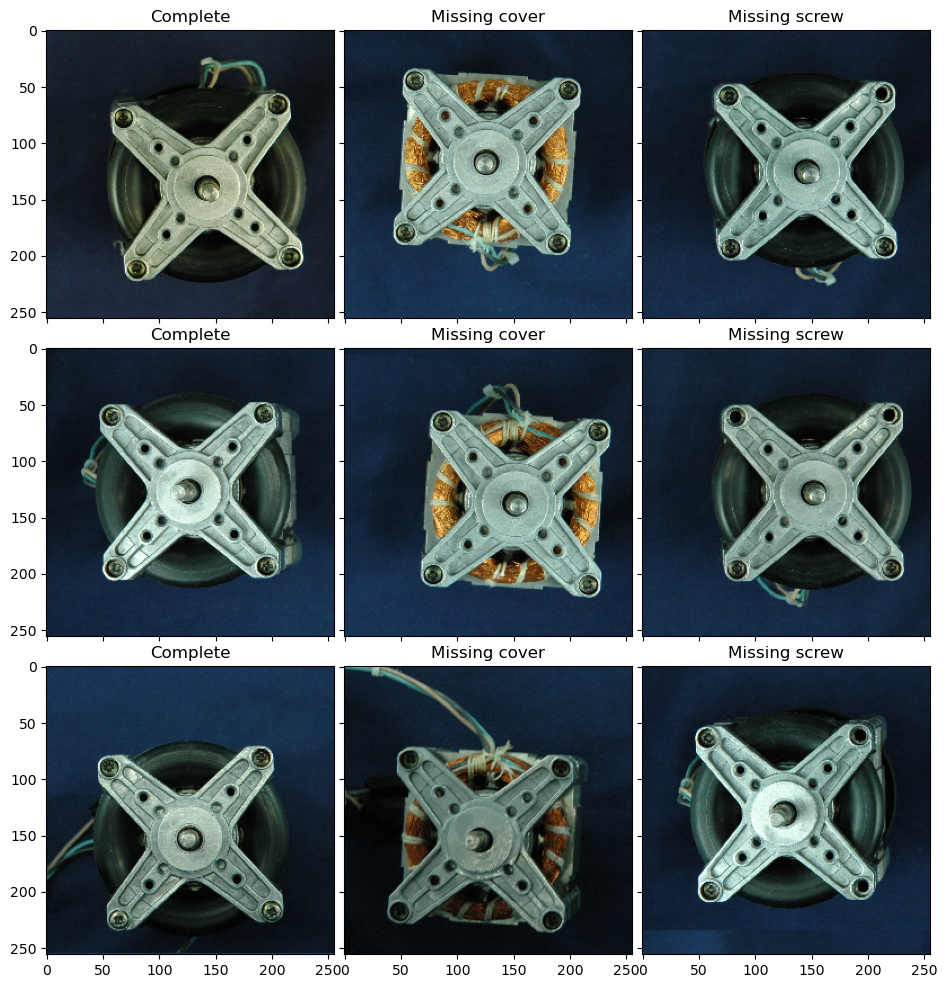

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=(0.1, 0.3))

#features, labels = load_features_labels("./data/top", size=(1024, 1024), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw']
for i, ax in enumerate(grid):
    selectedClass = classes[i%3] # Select class
    images = np.array(features)[np.array(labels)==selectedClass] # Preselect images based on class
    image = images[i//3] # Select image 
    ax.imshow(image) # Plot image
    ax.set_title(selectedClass) # Assign class as image title
plt.show()

In [7]:
from collections import Counter
print(Counter(labels))

Counter({'Complete': 61, 'Missing screw': 42, 'Missing cover': 14})


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, stratify=labels, random_state=42)

In [9]:
from sklearn.preprocessing import OneHotEncoder

print("Label of first sample before OneHot encoding:", y_train[0])
enc = OneHotEncoder(sparse=False) # Generate Encoder
y_train = enc.fit_transform(y_train.reshape(-1, 1))
print("Label of first sample after OneHot encoding:", y_train[0])
y_test = enc.transform(y_test.reshape(-1, 1))

Label of first sample before OneHot encoding: Complete
Label of first sample after OneHot encoding: [1. 0. 0.]


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(16, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 global_max_pooling2d (Globa  (None, 32)               0

In [12]:
from tensorflow.keras.optimizers import Adam

optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [13]:
model.fit(np.array(X_train), np.array(y_train), epochs = 25, batch_size = 32, validation_split=0.1, verbose = 1)


Epoch 1/25
3/3 [==============================] - 3s 500ms/step - loss: 14.9909 - accuracy: 0.1806 - val_loss: 2.6055 - val_accuracy: 0.4444
Epoch 2/25
3/3 [==============================] - 1s 174ms/step - loss: 2.7351 - accuracy: 0.5139 - val_loss: 2.1706 - val_accuracy: 0.6667
Epoch 3/25
3/3 [==============================] - 1s 167ms/step - loss: 2.7922 - accuracy: 0.5417 - val_loss: 2.1656 - val_accuracy: 0.7778
Epoch 4/25
3/3 [==============================] - 1s 173ms/step - loss: 2.4621 - accuracy: 0.5833 - val_loss: 1.9025 - val_accuracy: 0.6667
Epoch 5/25
3/3 [==============================] - 1s 170ms/step - loss: 1.9528 - accuracy: 0.6111 - val_loss: 1.5819 - val_accuracy: 0.6667
Epoch 6/25
3/3 [==============================] - 1s 173ms/step - loss: 1.3761 - accuracy: 0.6667 - val_loss: 0.8325 - val_accuracy: 0.7778
Epoch 7/25
3/3 [==============================] - 1s 186ms/step - loss: 1.0282 - accuracy: 0.6250 - val_loss: 1.4564 - val_accuracy: 0.4444
Epoch 8/25
3/3 [===

In [14]:
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report
    
    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

2/2 [==============================] - 0s 13ms/step
               precision    recall  f1-score   support

     Complete       0.76      0.68      0.72        19
Missing cover       1.00      0.50      0.67         4
Missing screw       0.59      0.77      0.67        13

     accuracy                           0.69        36
    macro avg       0.78      0.65      0.69        36
 weighted avg       0.73      0.69      0.70        36



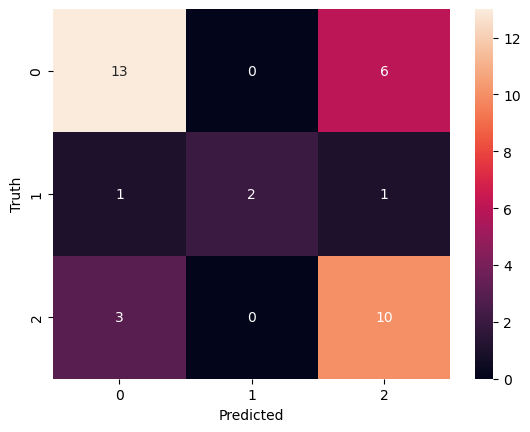

In [15]:
evaluate_model(X_test, y_test, model)

## Improve results: 

###  More Images - Image Augmentation

In [ ]:
print(Counter(labels))

In [16]:
MC_Images, MC_labels = load_features_labels("./top", size=(256,256), color=True, flatten=False, identifiers=['MC'])
MC_Images = np.asarray(MC_Images)
MC_labels = np.asarray(MC_labels)
print("Shape feature vector:", MC_Images.shape)
print("Shape label vector:", MC_labels.shape)

Shape feature vector: (14, 256, 256, 3)
Shape label vector: (14,)


In [17]:
import keras_cv

C:\Users\sohan\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
MC_aug4 = []
lab_aug = []
for image in MC_Images:
    img_aug = keras_cv.layers.RandAugment(value_range=(0, 255), magnitude = 0.2)(image)
    MC_aug4.append(img_aug)
    lab_aug.append('Missing cover')
    img_aug = keras_cv.layers.RandAugment(value_range=(0, 255), magnitude = 0.3)(image)
    MC_aug4.append(img_aug)
    lab_aug.append('Missing cover')

In [19]:
MC_aug4 = np.asarray(MC_aug4)
MC_aug4.shape

(28, 256, 256, 3)

In [20]:
features_aug = np.vstack((features, MC_aug4))

In [21]:
features_aug.shape

(145, 256, 256, 3)

In [22]:
lab_aug = np.asarray(lab_aug)

In [23]:
labels_aug = np.concatenate((labels, lab_aug))

In [24]:
labels_aug.shape

(145,)

In [25]:
print(Counter(labels_aug))

Counter({'Complete': 61, 'Missing cover': 42, 'Missing screw': 42})


In [26]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_aug, labels_aug, train_size=0.7, stratify=labels_aug, random_state=42)

In [27]:
from sklearn.preprocessing import OneHotEncoder

print("Label of first sample before OneHot encoding:", y_train2[0])
enc = OneHotEncoder(sparse=False) # Generate Encoder
y_train2 = enc.fit_transform(y_train2.reshape(-1, 1))
print("Label of first sample after OneHot encoding:", y_train2[0])
y_test2 = enc.transform(y_test2.reshape(-1, 1))

Label of first sample before OneHot encoding: Complete
Label of first sample after OneHot encoding: [1. 0. 0.]


In [28]:
model2=model

In [29]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.001)
model2.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [30]:
model2.fit(np.array(X_train2), np.array(y_train2), epochs = 25, batch_size = 32, validation_split=0.1, verbose = 1)

Epoch 1/25
3/3 [==============================] - 2s 531ms/step - loss: 2.4700 - accuracy: 0.6000 - val_loss: 1.2541 - val_accuracy: 0.5455
Epoch 2/25
3/3 [==============================] - 1s 266ms/step - loss: 1.5095 - accuracy: 0.5444 - val_loss: 0.6092 - val_accuracy: 0.8182
Epoch 3/25
3/3 [==============================] - 1s 266ms/step - loss: 0.7601 - accuracy: 0.7667 - val_loss: 0.6687 - val_accuracy: 0.7273
Epoch 4/25
3/3 [==============================] - 1s 237ms/step - loss: 0.7547 - accuracy: 0.7222 - val_loss: 0.3678 - val_accuracy: 0.8182
Epoch 5/25
3/3 [==============================] - 1s 247ms/step - loss: 0.4139 - accuracy: 0.8889 - val_loss: 1.2091 - val_accuracy: 0.6364
Epoch 6/25
3/3 [==============================] - 1s 235ms/step - loss: 0.4105 - accuracy: 0.8111 - val_loss: 0.5583 - val_accuracy: 0.9091
Epoch 7/25
3/3 [==============================] - 1s 242ms/step - loss: 0.2609 - accuracy: 0.9333 - val_loss: 0.4246 - val_accuracy: 0.8182
Epoch 8/25
3/3 [====

2/2 [==============================] - 0s 38ms/step
               precision    recall  f1-score   support

     Complete       0.71      0.83      0.77        18
Missing cover       1.00      0.77      0.87        13
Missing screw       0.77      0.77      0.77        13

     accuracy                           0.80        44
    macro avg       0.83      0.79      0.80        44
 weighted avg       0.81      0.80      0.80        44



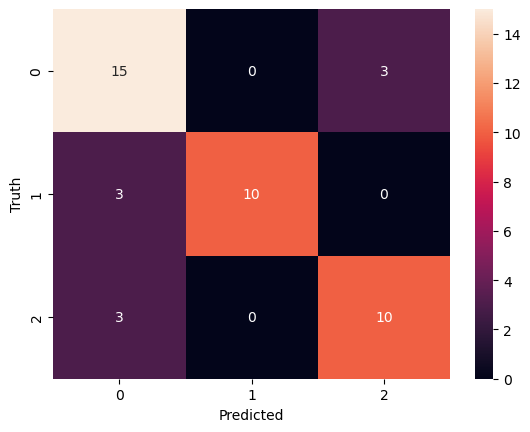

In [31]:
evaluate_model(X_test2, y_test2, model2)

In [32]:
model3=model

In [33]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.001)
model3.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [34]:
from sklearn.utils.class_weight import compute_sample_weight
model3.fit(np.array(X_train), np.array(y_train), epochs = 15, batch_size = 32, validation_split=0.1, 
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))


Epoch 1/15
3/3 [==============================] - 1s 287ms/step - loss: 0.7699 - accuracy: 0.6944 - val_loss: 0.3795 - val_accuracy: 0.6667
Epoch 2/15
3/3 [==============================] - 1s 201ms/step - loss: 0.6435 - accuracy: 0.7361 - val_loss: 0.0421 - val_accuracy: 1.0000
Epoch 3/15
3/3 [==============================] - 1s 200ms/step - loss: 0.0769 - accuracy: 0.9861 - val_loss: 0.1913 - val_accuracy: 0.7778
Epoch 4/15
3/3 [==============================] - 1s 176ms/step - loss: 0.1149 - accuracy: 0.8889 - val_loss: 0.2758 - val_accuracy: 0.6667
Epoch 5/15
3/3 [==============================] - 1s 163ms/step - loss: 0.0917 - accuracy: 0.9444 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 6/15
3/3 [==============================] - 1s 184ms/step - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 7/15
3/3 [==============================] - 1s 178ms/step - loss: 0.0618 - accuracy: 0.9861 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 8/15
3/3 [====

In [36]:
model3.fit(np.array(X_train2), np.array(y_train2), epochs = 15, batch_size = 32, validation_split=0.1, verbose = 1)

Epoch 1/15
3/3 [==============================] - 1s 369ms/step - loss: 0.0267 - accuracy: 0.9889 - val_loss: 0.4603 - val_accuracy: 0.9091
Epoch 2/15
3/3 [==============================] - 1s 246ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.4597 - val_accuracy: 0.9091
Epoch 3/15
3/3 [==============================] - 1s 248ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.3134 - val_accuracy: 0.9091
Epoch 4/15
3/3 [==============================] - 1s 262ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.2733 - val_accuracy: 0.9091
Epoch 5/15
3/3 [==============================] - 1s 258ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.3414 - val_accuracy: 0.9091
Epoch 6/15
3/3 [==============================] - 1s 253ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.3890 - val_accuracy: 0.9091
Epoch 7/15
3/3 [==============================] - 1s 230ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3743 - val_accuracy: 0.9091
Epoch 8/15
3/3 [====

2/2 [==============================] - 0s 26ms/step
               precision    recall  f1-score   support

     Complete       0.84      0.89      0.86        18
Missing cover       1.00      0.92      0.96        13
Missing screw       0.85      0.85      0.85        13

     accuracy                           0.89        44
    macro avg       0.90      0.89      0.89        44
 weighted avg       0.89      0.89      0.89        44



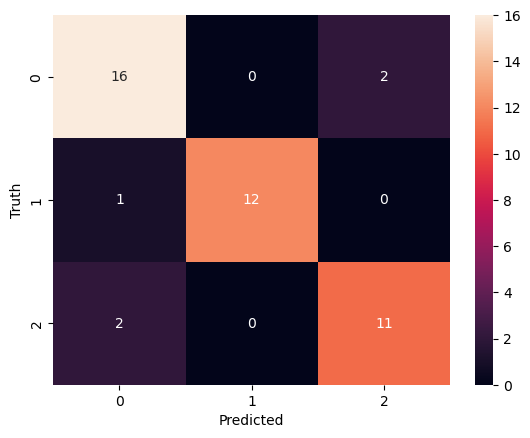

In [37]:
evaluate_model(X_test2, y_test2, model3)